In [90]:
import copy
import os
from pathlib import Path
from itertools import chain, combinations

import biodivine_aeon as ba

MODELS_FOLDER = ".\\models"

def load_boolean_network(model):
    file = Path(os.path.join(MODELS_FOLDER, model)).read_text()
    return ba.BooleanNetwork.from_aeon(file)

In [91]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\windows_10_msbuild_Release_graphviz-5.0.1-win32\\Graphviz\\bin'

In [92]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [93]:
model = load_boolean_network('myeloid_witness.aeon')
vars = model.variables()
rg = model.graph()

myeloid_stg = ba.SymbolicAsyncGraph(model)
attractors = ba.find_attractors(myeloid_stg)

In [94]:
print(attractors)

[ColoredVertexSet(cardinality = 1, unique vertices = 1, unique colors = 1), ColoredVertexSet(cardinality = 1, unique vertices = 1, unique colors = 1), ColoredVertexSet(cardinality = 1, unique vertices = 1, unique colors = 1), ColoredVertexSet(cardinality = 1, unique vertices = 1, unique colors = 1), ColoredVertexSet(cardinality = 1, unique vertices = 1, unique colors = 1), ColoredVertexSet(cardinality = 1, unique vertices = 1, unique colors = 1)]


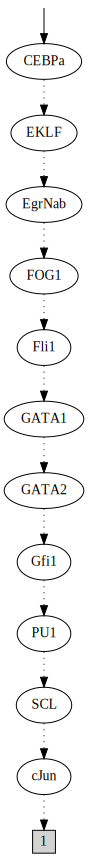

In [95]:
import graphviz

graphviz.Source(attractors[0].to_bdd().to_dot(myeloid_stg.bdd_variables())) # All 0 - irrelevant attractor

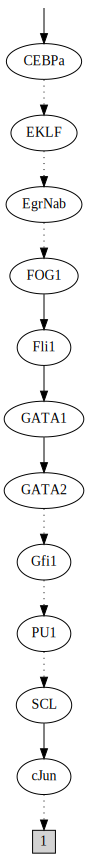

In [96]:
graphviz.Source(attractors[1].to_bdd().to_dot(myeloid_stg.bdd_variables())) # FOG1, Fli1, GATA1, SCL true -> megakaryocytes

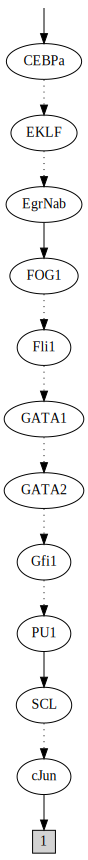

In [97]:
graphviz.Source(attractors[2].to_bdd().to_dot(myeloid_stg.bdd_variables())) # EgrNab, PU1, Cjun true -> pathology

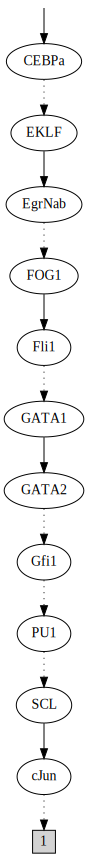

In [98]:
graphviz.Source(attractors[3].to_bdd().to_dot(myeloid_stg.bdd_variables())) # EKLF, FOG1, GATA1 true -> erythrocytes

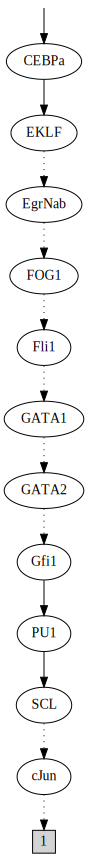

In [99]:
graphviz.Source(attractors[4].to_bdd().to_dot(myeloid_stg.bdd_variables())) # CEBPa, Gfi1, PU1 -> granulocytes

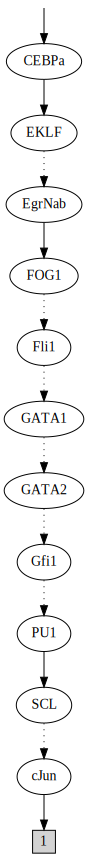

In [100]:
graphviz.Source(attractors[5].to_bdd().to_dot(myeloid_stg.bdd_variables()))  # CEBPa, EgrNab, PU1, cJun -> monocytes

In [101]:
attractors[0].vertices().list_vertices()[0]

[False, False, False, False, False, False, False, False, False, False, False]

In [102]:
relevant_attractors = {'megakaryocytes': attractors[1], 'granulocytes': attractors[4], 'erythrocytes': attractors[3], 'monocytes': attractors[5]}
min_controls_global = {}

for target_key, target in relevant_attractors.items():
    for source_key, source in relevant_attractors.items():
        if source_key == target_key:
            continue

        min_control_size = 0
        control_found = False
        min_controls = []
        for perturbed_vars in powerset(vars):
            if control_found and len(perturbed_vars) > min_control_size:
                break
            for true_comb in powerset(perturbed_vars):
                pg = ba.PerturbationGraph(model)
                cm = pg.temporary_control(source.vertices().list_vertices()[0], target.vertices().list_vertices()[0])
                for v in vars:
                    if v in perturbed_vars:
                        cm.require_perturbation(v)
                        if v in true_comb:
                            cm.require_perturbation(v, True)
                        else:
                            cm.require_perturbation(v, False)
                    else:
                        cm.exclude_perturbation(v)
                if cm.controllable_colors_cardinality() > 0.0:
                    min_control_size = len(perturbed_vars)
                    control_found = True
                    resolved_vars = [model.get_variable_name(x) for x in perturbed_vars]
                    resolved_true_vars = [model.get_variable_name(x) for x in true_comb]
                    print(f'found control from {source_key} to {target_key} ', resolved_vars, resolved_true_vars)
                    min_controls.append((resolved_vars, resolved_true_vars))
            min_controls_global[f'from {source_key} to {target_key}'] = min_controls

found control from granulocytes to megakaryocytes  ['Fli1', 'PU1'] ['Fli1']
found control from erythrocytes to megakaryocytes  ['EKLF'] []
found control from erythrocytes to megakaryocytes  ['Fli1'] ['Fli1']
found control from monocytes to megakaryocytes  ['Fli1', 'PU1'] ['Fli1']
found control from megakaryocytes to granulocytes  ['CEBPa', 'EgrNab'] ['CEBPa']
found control from megakaryocytes to granulocytes  ['CEBPa', 'Gfi1'] ['CEBPa', 'Gfi1']
found control from megakaryocytes to granulocytes  ['CEBPa', 'cJun'] ['CEBPa']
found control from erythrocytes to granulocytes  ['CEBPa', 'EgrNab'] ['CEBPa']
found control from erythrocytes to granulocytes  ['CEBPa', 'Gfi1'] ['CEBPa', 'Gfi1']
found control from erythrocytes to granulocytes  ['CEBPa', 'cJun'] ['CEBPa']
found control from monocytes to granulocytes  ['EgrNab'] []
found control from monocytes to granulocytes  ['Gfi1'] ['Gfi1']
found control from monocytes to granulocytes  ['PU1'] []
found control from monocytes to granulocytes  ['cJ

In [103]:
print(min_controls_global)

{'from granulocytes to megakaryocytes': [(['Fli1', 'PU1'], ['Fli1'])], 'from erythrocytes to megakaryocytes': [(['EKLF'], []), (['Fli1'], ['Fli1'])], 'from monocytes to megakaryocytes': [(['Fli1', 'PU1'], ['Fli1'])], 'from megakaryocytes to granulocytes': [(['CEBPa', 'EgrNab'], ['CEBPa']), (['CEBPa', 'Gfi1'], ['CEBPa', 'Gfi1']), (['CEBPa', 'cJun'], ['CEBPa'])], 'from erythrocytes to granulocytes': [(['CEBPa', 'EgrNab'], ['CEBPa']), (['CEBPa', 'Gfi1'], ['CEBPa', 'Gfi1']), (['CEBPa', 'cJun'], ['CEBPa'])], 'from monocytes to granulocytes': [(['EgrNab'], []), (['Gfi1'], ['Gfi1']), (['PU1'], []), (['cJun'], [])], 'from megakaryocytes to erythrocytes': [(['EKLF'], ['EKLF']), (['Fli1'], [])], 'from granulocytes to erythrocytes': [(['EKLF', 'GATA1', 'GATA2'], ['EKLF', 'GATA1', 'GATA2']), (['EKLF', 'GATA1', 'PU1'], ['EKLF', 'GATA1']), (['EKLF', 'GATA2', 'PU1'], ['EKLF', 'GATA2']), (['Fli1', 'GATA1', 'GATA2'], ['GATA1', 'GATA2']), (['Fli1', 'GATA1', 'PU1'], ['GATA1']), (['Fli1', 'GATA2', 'PU1'],

In [104]:
model_u = load_boolean_network('myeloid_unknown.aeon')

In [105]:
def get_att_colors(sg: ba.PerturbationGraph, a: ba.ColoredVertexSet):
    attractor = sg.as_original().fix_vertex(a.vertices().list_vertices()[0])
    bwd = ba.reach_bwd(sg.as_original(), attractor)
    brk = False
    while not brk:
        brk = True
        for v in vars:
            step = sg.as_original().var_post(v, attractor).minus(attractor)
            if not step.is_empty():
                not_att = step.minus(bwd).colors()
                attractor = attractor.union(step).minus_colors(not_att)
                brk = False

    return attractor.colors()

print(get_att_colors(ba.PerturbationGraph(model_u), attractors[1]).cardinality())

7509876736.0


In [106]:
print(ba.PerturbationGraph(model_u).unit_colors().cardinality())

9710862336.0


In [107]:
for target_key, target in relevant_attractors.items():
    target_colors = get_att_colors(ba.PerturbationGraph(model_u), target)
    for source_key, source in relevant_attractors.items():
        if source_key == target_key:
            continue
        controls = min_controls_global[f'from {source_key} to {target_key}']
        for c, t in controls:
            pg = ba.PerturbationGraph(model_u)
            cm = pg.temporary_control(source.vertices().list_vertices()[0], target.vertices().list_vertices()[0], target_colors)
            gc = cm.controllable_colors_cardinality()
            for v in vars:
                if model.get_variable_name(v) in c:
                    if model.get_variable_name(v) in t:
                        cm.require_perturbation(v, True)
                    else:
                        cm.require_perturbation(v, False)
                else:
                    cm.exclude_perturbation(v)
            print(f'control from {source_key} to {target_key} {c} {t} has cardinality {cm.controllable_colors_cardinality()} which is {cm.controllable_colors_cardinality() / gc} robustness')

control from granulocytes to megakaryocytes ['Fli1', 'PU1'] ['Fli1'] has cardinality 1980108.0 which is 0.5399903788780376 robustness
control from erythrocytes to megakaryocytes ['EKLF'] [] has cardinality 3666932.0 which is 1.0 robustness
control from erythrocytes to megakaryocytes ['Fli1'] ['Fli1'] has cardinality 3666932.0 which is 1.0 robustness
control from monocytes to megakaryocytes ['Fli1', 'PU1'] ['Fli1'] has cardinality 1980108.0 which is 0.5399903788780376 robustness
control from megakaryocytes to granulocytes ['CEBPa', 'EgrNab'] ['CEBPa'] has cardinality 1106488.0 which is 0.4705175962307156 robustness
control from megakaryocytes to granulocytes ['CEBPa', 'Gfi1'] ['CEBPa', 'Gfi1'] has cardinality 1106488.0 which is 0.4705175962307156 robustness
control from megakaryocytes to granulocytes ['CEBPa', 'cJun'] ['CEBPa'] has cardinality 1106488.0 which is 0.4705175962307156 robustness
control from erythrocytes to granulocytes ['CEBPa', 'EgrNab'] ['CEBPa'] has cardinality 1106488.